# Utility functions

In [2]:
import sys
sys.path.insert(0,'../') 
# from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split
from torch.utils.data import Subset, DataLoader, random_split

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd 

import argparse

import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter


# import models_vit
import sys
import os
import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
# import models_mae
import torch; print(f'numpy version: {np.__version__}\nCUDA version: {torch.version.cuda} - Torch versteion: {torch.__version__} - device count: {torch.cuda.device_count()}')

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.optim as optim
import torch.nn as nn
import torch

import PIL
import pandas as pd
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score
import numpy as np
from torchvision import datasets, transforms
from timm.data import create_transform
# from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

IMAGENET_DEFAULT_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_DEFAULT_STD = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * IMAGENET_DEFAULT_STD + IMAGENET_DEFAULT_MEAN) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def plot_multiclass_roc_curve(all_labels, all_predictions, EXPERIMENT_NAME="."):
    # Step 1: Label Binarization
    label_binarizer = LabelBinarizer()
    y_onehot = label_binarizer.fit_transform(all_labels)
    all_predictions_hot = label_binarizer.transform(all_predictions)

    # Step 2: Calculate ROC curves
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    unique_classes = range(y_onehot.shape[1])
    for i in unique_classes:
        fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], all_predictions_hot[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Step 3: Plot ROC curves
    fig, ax = plt.subplots(figsize=(8, 8))

    # Micro-average ROC curve
    fpr_micro, tpr_micro, _ = roc_curve(y_onehot.ravel(), all_predictions_hot.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(
        fpr_micro,
        tpr_micro,
        label=f"micro-average ROC curve (AUC = {roc_auc_micro:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    # Macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in unique_classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in unique_classes:
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(unique_classes)
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    plt.plot(
        fpr_macro,
        tpr_macro,
        label=f"macro-average ROC curve (AUC = {roc_auc_macro:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    # Individual class ROC curves with unique colors
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_classes)))
    for class_id, color in zip(unique_classes, colors):
        plt.plot(
            fpr[class_id],
            tpr[class_id],
            color=color,
            label=f"ROC curve for Class {class_id} (AUC = {roc_auc[class_id]:.2f})",
            linewidth=2,
        )

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2)  # Add diagonal line for reference
    plt.axis("equal")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\n to One-vs-Rest multiclass")
    plt.legend()
    plt.savefig(f'{EXPERIMENT_NAME}/roc_curve.png')
    plt.show()


def build_dataset(is_train, args):
    transform = build_transform(is_train, args)

    root = os.path.join(args.data_path, 'train' if is_train else 'val')
    dataset = datasets.ImageFolder(root, transform=transform)

    print(dataset)

    return dataset


def build_transform(is_train, args):
    mean = IMAGENET_DEFAULT_MEAN
    std = IMAGENET_DEFAULT_STD
    # train transform
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=args.input_size,
            is_training=True,
            color_jitter=args.color_jitter,
            auto_augment=args.aa,
            interpolation='bicubic',
            re_prob=args.reprob,
            re_mode=args.remode,
            re_count=args.recount,
            mean=mean,
            std=std,
        )
        return transform

    # eval transform
    t = []
    if args.input_size <= 224:
        crop_pct = 224 / 256
    else:
        crop_pct = 1.0
    size = int(args.input_size / crop_pct)
    t.append(
        transforms.Resize(size, interpolation=PIL.Image.BICUBIC),  # to maintain same ratio w.r.t. 224 images
    )
    t.append(transforms.CenterCrop(args.input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(mean, std))
    return transforms.Compose(t)

# Set the seed for PyTorch
torch.manual_seed(42)

2024-05-08 10:57:46.118030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 10:57:46.118368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 10:57:46.124925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 10:57:46.149868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 10:57:49.894135: W tensorflow/compiler/tf2

numpy version: 1.26.4
CUDA version: 11.8 - Torch versteion: 2.0.0+cu118 - device count: 2


# MLP

In [84]:
# Read embeddings CSV files
train_embeddings = pd.read_csv(f'{train_path}/train_embeddings.csv')
val_embeddings = pd.read_csv(f'{val_path}/val_embeddings.csv')


# Split the data into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)


X_test = val_embeddings.iloc[:, :-1].values      # Features
y_test = val_embeddings.iloc[:, -1].values       # Labels

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([3994, 960]) (3994,)
torch.Size([705, 960]) (705,)
(850, 960) (850,)


In [ ]:

print("GridSearch over a list of neighbors: {0}".format(l_k))
_ = knn_gscv.fit(x, y)

In [105]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

# we use stratified folds
from sklearn.pipeline import Pipeline

n_folds = 10
skf = StratifiedKFold(n_folds, shuffle=True)

mlp_classifier = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('mlpc', MLPClassifier(solver='adam', 
                                              activation='relu',
                                              tol=1.e-4, 
                                              max_iter=1000,
                                              warm_start=False,
                                              shuffle=True))])

l_hidden_layer_sizes = [(20,), (20, 20)]
l_alpha = [10.**k for k in range(-6, 4)]

param_grid = {'mlpc__alpha': l_alpha, 'mlpc__hidden_layer_sizes': l_hidden_layer_sizes}

mlpc_gscv = GridSearchCV(mlp_classifier, 
                         param_grid=param_grid, 
                         cv=skf, 
                         scoring='accuracy', 
                         return_train_score=True, 
                         n_jobs=-1, 
                         verbose=1)

t_0 = time.time() 
_ = mlpc_gscv.fit(X_train, y_train)
t_1 = time.time() 
print("\nmlp_grid_search_time: {0:.2}f".format((t_1 - t_0)/60.))


Fitting 10 folds for each of 20 candidates, totalling 200 fits

mlp_grid_search_time: 3e+01f


In [112]:
import joblib
# saving alpha_search in a pickle    
joblib.dump(mlpc_gscv, 'mlp_classifier_gscv.joblib')

['mlp_classifier_gscv.joblib']

In [113]:
df_cv_estimator = pd.DataFrame.from_dict(mlpc_gscv.cv_results_)

display(df_cv_estimator[["param_mlpc__alpha", "param_mlpc__hidden_layer_sizes", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())


,param_mlpc__alpha,param_mlpc__hidden_layer_sizes,mean_test_score
19,1000.0,"(20, 20)",0.398598
18,1000.0,"(20,)",0.398598
17,100.0,"(20, 20)",0.398598
16,100.0,"(20,)",0.398598
14,10.0,"(20,)",0.297949


best alpha: 100.000000	
alpha_min: 0.000001	alpha_max: 1000.000000
best_hidden_layer_sizes (20,) 
acc: 0.399


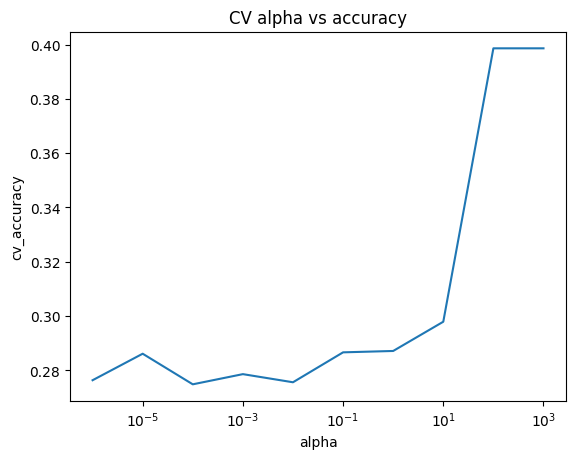

In [114]:
mlpc_gscv = joblib.load('mlp_classifier_gscv.joblib')

best_alpha = mlpc_gscv.best_params_['mlpc__alpha'] 
print("best alpha: %.6f\t" % best_alpha)
print("alpha_min: %f\talpha_max: %f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))

best_hidden_layer_sizes = mlpc_gscv.best_params_['mlpc__hidden_layer_sizes'] 
print("best_hidden_layer_sizes", best_hidden_layer_sizes, "\nacc: %.3f" % mlpc_gscv.best_score_) 

idx_best_hidden_layer_sizes = [tup == best_hidden_layer_sizes for tup in df_cv_estimator['param_mlpc__hidden_layer_sizes'].values]
idx_best_hidden_layer_sizes = np.array(idx_best_hidden_layer_sizes)

plt.title("CV alpha vs accuracy")
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("cv_accuracy")
_ = plt.plot( df_cv_estimator[idx_best_hidden_layer_sizes]['param_mlpc__alpha'], 
              df_cv_estimator[idx_best_hidden_layer_sizes]['mean_test_score'])


In [118]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV
### CV accuracy, recall and precision of best model
y_pred = cross_val_predict(mlpc_gscv.best_estimator_, X_train, y_train, cv=skf, n_jobs=2)

acc    = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)
prec   = precision_score(y, y_pred) 

print("acc: %.3f\trecall: %.3f\tprecision: %.3f" % (acc, recall, prec))

print("\nconfusion matrix:\n", confusion_matrix(y, y_pred))

/home/sebastian/anaconda3/envs/sebasmos/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/sebastian/anaconda3/envs/sebasmos/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

# Simple fit MLP

In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier


mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), activation='relu',
                               solver='adam', alpha=0.0001, batch_size='auto',
                               learning_rate='constant', learning_rate_init=0.001,
                               max_iter=200, shuffle=True, random_state=42,
                               verbose=True, early_stopping=True, validation_fraction=0.1,
                               n_iter_no_change=20)  # Increased dropout rate
# mlp_classifier = MLPClassifier(random_state=1, max_iter=300)
# Train the classifier
mlp_classifier.fit(X_train, y_train)

# Evaluate the classifier
train_accuracy = accuracy_score(y_train, mlp_classifier.predict(X_train))
val_accuracy = accuracy_score(y_val, mlp_classifier.predict(X_val))
test_accuracy = accuracy_score(y_test, mlp_classifier.predict(X_test))

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Iteration 1, loss = 2.04481389
Validation score: 0.275000
Iteration 2, loss = 1.25054035
Validation score: 0.312500
Iteration 3, loss = 0.94943818
Validation score: 0.287500
Iteration 4, loss = 0.74884293
Validation score: 0.290000
Iteration 5, loss = 0.59651628
Validation score: 0.282500
Iteration 6, loss = 0.47327800
Validation score: 0.292500
Iteration 7, loss = 0.37418169
Validation score: 0.285000
Iteration 8, loss = 0.29352812
Validation score: 0.285000
Iteration 9, loss = 0.23084078
Validation score: 0.282500
Iteration 10, loss = 0.18386750
Validation score: 0.292500
Iteration 11, loss = 0.14786722
Validation score: 0.280000
Iteration 12, loss = 0.12080635
Validation score: 0.280000
Iteration 13, loss = 0.09993313
Validation score: 0.282500
Iteration 14, loss = 0.08379882
Validation score: 0.287500
Iteration 15, loss = 0.07130639
Validation score: 0.290000
Iteration 16, loss = 0.06136289
Validation score: 0.295000
Iteration 17, loss = 0.05343105
Validation score: 0.285000
Iterat

In [ ]:
# Full predictions on test data
y_pred = mlp_classifier.predict(X_test)


In [98]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
epochs=1000
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).cuda()
y_train_tensor = torch.tensor(y_train, dtype=torch.long).cuda()
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).cuda()
y_val_tensor = torch.tensor(y_val, dtype=torch.long).cuda()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).cuda()

# Create DataLoader for training and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64)

class MLP(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, len(np.unique(y_train)))
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize MLP model and move to CUDA
model = MLP(dropout_rate=0.5).cuda()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Adding L2 regularization

# Training loop with early stopping
best_val_accuracy = 0.0
best_model_state_dict = None
patience = 10
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_accuracy = 0.0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_accuracy += accuracy_score(labels.cpu(), torch.argmax(outputs, dim=1).cpu().numpy())
        val_accuracy /= len(val_loader)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state_dict = model.state_dict()
            patience = 10  # Reset patience if a new best validation accuracy is achieved
        else:
            patience -= 1
            if patience == 0:
                break

# Load the best model state dict
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)

# Evaluate the best model on test set
model.eval()
with torch.no_grad():
    y_test_pred = torch.argmax(model(X_test_tensor), dim=1).cpu().numpy()

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

/tmp/ipykernel_3090300/298482586.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).cuda()
/tmp/ipykernel_3090300/298482586.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=torch.float32).cuda()


Test Accuracy: 0.21058823529411766


# old method..

In [67]:
output_size = 5  # Example output size
hidden_images = [64]  # Example hidden layer sizes

In [80]:
import torch
import torch.nn as nn

class SimpleClassifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[64], dropout_prob=0.2):
        super(SimpleClassifier, self).__init__()
        
        self.fc_layers = self._create_fc_layers(input_size, hidden_sizes, dropout_prob)
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
    
    def _create_fc_layers(self, input_size, hidden_sizes, dropout_prob):
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_prob))
            prev_size = hidden_size
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.fc_layers(x)
        x = self.output_layer(x)
        return x


X_train_shape = X_train.shape
input_size = X_train_shape[1]  # Input size based on the feature dimension
output_size = 5  # Example output size
hidden_sizes = [64]  # Example hidden layer sizes

# Instantiate the model
classifier_model = SimpleClassifier(input_size, output_size, hidden_sizes)


# Forward pass
output = classifier_model(X_train_tensor)
print("Output shape:", output.shape)  # Should be (7680, 5)
classifier_model

Output shape: torch.Size([4699, 5])


SimpleClassifier(
  (fc_layers): Sequential(
    (0): Linear(in_features=960, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (output_layer): Linear(in_features=64, out_features=5, bias=True)
)

In [81]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)


y_train_np = y_train.astype(int)

# Count occurrences of each class label
class_counts = np.bincount(y_train_np, minlength=5)

# Calculate class weights
total_samples = len(y_train_np)
num_classes = 5
class_weights = total_samples / (num_classes * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
class_weights


/tmp/ipykernel_3090300/1161299652.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)


tensor([0.8273, 0.5031, 0.8942, 4.8948, 2.0792])

In [82]:
# Move data and model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
class_weights = class_weights.to(device)
classifier_model = SimpleClassifier(input_size, output_size, hidden_sizes)
classifier_model = classifier_model.to(device)

/home/sebastian/anaconda3/envs/sebasmos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/10], Train Loss: 1.4812, Val Loss: 1.4227, F1 Score: 0.2773, Precision: 0.2491, Accuracy: 0.3952


/home/sebastian/anaconda3/envs/sebasmos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/10], Train Loss: 1.2253, Val Loss: 1.4628, F1 Score: 0.2994, Precision: 0.2725, Accuracy: 0.3530


/home/sebastian/anaconda3/envs/sebasmos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/10], Train Loss: 1.0483, Val Loss: 1.5457, F1 Score: 0.2989, Precision: 0.2832, Accuracy: 0.3325


/home/sebastian/anaconda3/envs/sebasmos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/10], Train Loss: 0.8682, Val Loss: 1.6647, F1 Score: 0.2961, Precision: 0.2849, Accuracy: 0.3193


/home/sebastian/anaconda3/envs/sebasmos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/10], Train Loss: 0.7026, Val Loss: 1.7979, F1 Score: 0.2957, Precision: 0.2841, Accuracy: 0.3169
Epoch [6/10], Train Loss: 0.5457, Val Loss: 1.9453, F1 Score: 0.2933, Precision: 0.2831, Accuracy: 0.3084
Epoch [7/10], Train Loss: 0.4134, Val Loss: 2.0546, F1 Score: 0.3007, Precision: 0.2914, Accuracy: 0.3157
Epoch [8/10], Train Loss: 0.3291, Val Loss: 2.1936, F1 Score: 0.2960, Precision: 0.2884, Accuracy: 0.3108
Epoch [9/10], Train Loss: 0.2572, Val Loss: 2.3038, F1 Score: 0.3096, Precision: 0.3037, Accuracy: 0.3205
Epoch [10/10], Train Loss: 0.2096, Val Loss: 2.4165, F1 Score: 0.3054, Precision: 0.2997, Accuracy: 0.3157


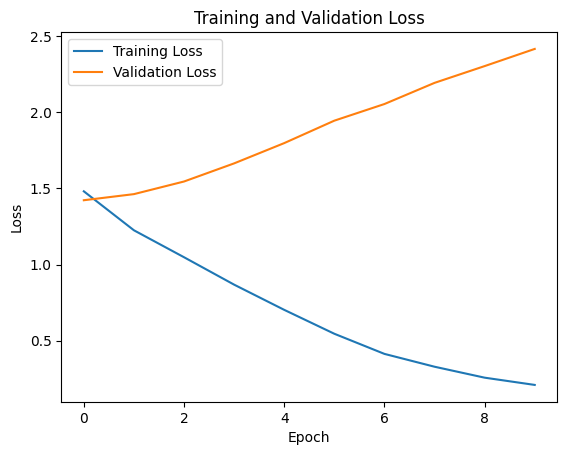

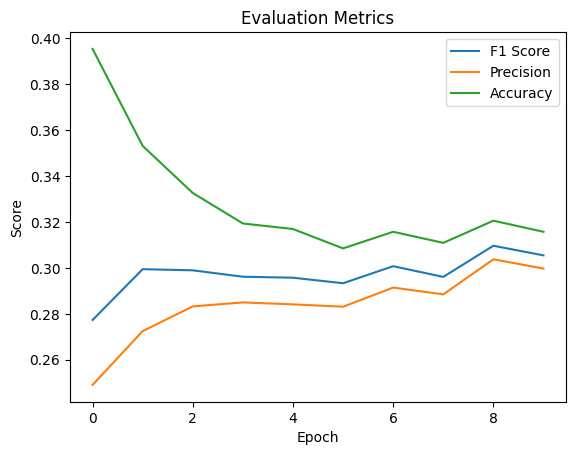

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, fbeta_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define your SimpleClassifier class here (same as before)

# Assuming you have X_train and y_train as your training data
# Preprocess the data (scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert them to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Define batch size and create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Instantiate the model
classifier_model = SimpleClassifier(input_size=X_train.shape[1], output_size=output_size, hidden_sizes=hidden_sizes)
classifier_model = classifier_model.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(classifier_model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_loss_history = []
val_loss_history = []
f1_score_history = []
precision_history = []
accuracy_history = []
# Initialize patience counter
patience = 50  # Adjust this value as needed

# Initialize variable to track epochs since last improvement
epochs_since_last_improvement = 0
# Training loop
num_epochs = 10
best_val_loss = float('inf')
for epoch in range(num_epochs):
    classifier_model.train()  # Set the model to training mode
    total_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = classifier_model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        total_train_loss += loss.item() * inputs.size(0)
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    # Calculate average training loss for the epoch
    average_train_loss = total_train_loss / len(train_loader.dataset)
    train_loss_history.append(average_train_loss)

    # Evaluate on validation set
    classifier_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_outputs = classifier_model(X_val_tensor.to(device))
        val_loss = criterion(val_outputs, y_val_tensor.to(device))
        val_loss_history.append(val_loss.item())

        # Get predictions for validation data
        val_predictions = val_outputs.argmax(dim=1)
        y_val_np = y_val_tensor.cpu().numpy()
        val_predictions_np = val_predictions.cpu().numpy()

        # Calculate evaluation metrics
        f1 = f1_score(y_val_np, val_predictions_np, average='weighted')
        precision = precision_score(y_val_np, val_predictions_np, average='weighted')
        accuracy = accuracy_score(y_val_np, val_predictions_np)
        f1_score_history.append(f1)
        precision_history.append(precision)
        accuracy_history.append(accuracy)

    # Print average loss and evaluation metrics for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, "
          f"Val Loss: {val_loss.item():.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, "
          f"Accuracy: {accuracy:.4f}")

    # Check for early stopping
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        epochs_since_last_improvement = 0  # Reset counter
    else:
        epochs_since_last_improvement += 1
        if epochs_since_last_improvement >= patience:
            print("Early stopping at epoch:", epoch)
            break
# Plot training and validation loss
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot evaluation metrics
plt.plot(f1_score_history, label='F1 Score')
plt.plot(precision_history, label='Precision')
plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.legend()
plt.show()